# Сегментация заказов Instacart по категориям (aisles)
*Дата создания ноутбука: 2025-05-02*

В этом исследовании мы:
1. Загрузим данные **Instacart**,
2. Представим каждый заказ как распределение покупок по категориям (aisle),
3. Подберём оптимальное число кластеров *k* с помощью силуэт‑метрики,
4. Кластеризуем заказы методом **K‑Means**,


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

plt.style.use('default')

In [2]:

# --- Параметры ---
DATA_DIR = Path(r'D:\instacart\archive')   # папка с CSV‑файлами
SAMPLE_SIZE = 20000             # подвыборка для силуэта
K_MIN, K_MAX = 2, 10            # диапазон k
RANDOM_STATE = 42


In [3]:

def read_csv_minimal(path, usecols=None, dtype=None):
    return pd.read_csv(path, usecols=usecols, dtype=dtype)

print('⏳ Загружаем таблицы…')
products = read_csv_minimal(
    DATA_DIR / 'products.csv',
    usecols=['product_id', 'aisle_id'],
    dtype={'product_id': 'int32', 'aisle_id': 'int16'}
)
orders = read_csv_minimal(
    DATA_DIR / 'orders.csv',
    usecols=['order_id', 'user_id'],
    dtype={'order_id': 'int32', 'user_id': 'int32'}
)
prior = read_csv_minimal(
    DATA_DIR / 'order_products__prior.csv',
    usecols=['order_id', 'product_id'],
    dtype={'order_id': 'int32', 'product_id': 'int32'}
)
train = read_csv_minimal(
    DATA_DIR / 'order_products__train.csv',
    usecols=['order_id', 'product_id'],
    dtype={'order_id': 'int32', 'product_id': 'int32'}
)
order_products = pd.concat([prior, train], ignore_index=True)
del prior, train
print('✅ Данные загружены')


⏳ Загружаем таблицы…
✅ Данные загружены


In [4]:
order_products

,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035
...,...,...
33819101,3421063,14233
33819102,3421063,35548
33819103,3421070,35951
33819104,3421070,16953


In [5]:
order_products = order_products.merge(products, on='product_id', how='left')
order_products

,order_id,product_id,aisle_id
0,2,33120,86
1,2,28985,83
2,2,9327,104
3,2,45918,19
4,2,30035,17
...,...,...,...
33819101,3421063,14233,115
33819102,3421063,35548,13
33819103,3421070,35951,91
33819104,3421070,16953,88


В результате многочисленных итераций сегментации было принято решение кластеризировать заказы по категориям товаров (aisles потомц что при создании order x item матрицы нужно огромное количество ресурсов (товаров примерно 50000, значит получиться матрица 3кк x 50к)) также было решено не учитывать категории с фруктами и овощами, потому что их в заказах абсолютное большенство, и также не учитывать не популярне категории

In [6]:
aisles = pd.read_csv(
        DATA_DIR / 'aisles.csv',
        dtype={'aisle_id': 'int16', 'aisle': 'category'}
    )

aisle_name = aisles.set_index('aisle_id')['aisle'].to_dict()


# Считаем количество заказов по каждой категории (aisle_id)
aisle_counts = order_products['aisle_id'].value_counts().reset_index()
aisle_counts.columns = ['aisle_id', 'num_orders']

# Добавим названия категорий
aisle_counts['aisle'] = aisle_counts['aisle_id'].map(aisle_name)

# Отсортируем по убыванию количества заказов
aisle_counts = aisle_counts.sort_values('num_orders', ascending=False)

print(aisle_counts)

     aisle_id  num_orders                       aisle
0          24     3792661                fresh fruits
1          83     3568630            fresh vegetables
2         123     1843806  packaged vegetables fruits
3         120     1507583                      yogurt
4          21     1021462             packaged cheese
..        ...         ...                         ...
129        44        9522                eye ear care
130       102        8909         baby bath body care
131        82        8466            baby accessories
132       132        6455                      beauty
133       113        5147                frozen juice

[134 rows x 3 columns]


In [7]:
# Топ-5 популярных
top_aisles_ids = aisle_counts.head(5)['aisle_id'].tolist()

# Категории менее 10,000 заказов
rare_aisles_ids = aisle_counts[aisle_counts['num_orders'] < 10000]['aisle_id'].tolist()

# Все категории, которые не должны попасть в матрицу
exclude_aisles = set(top_aisles_ids + rare_aisles_ids)
print("Исключаемые категории:", exclude_aisles)


Исключаемые категории: {132, 102, 10, 44, 113, 82, 83, 21, 24, 123, 120}


In [8]:
# #➋  фильтруем order_products
# filtered_order_products = order_products

In [9]:
print('\nСоздаём матрицу заказ × категория (без популярных и редких)…')

# ➊  список категорий, которые исключаем

# ➋  фильтруем order_products
filtered_order_products = order_products[~order_products['aisle_id'].isin(exclude_aisles)]

# ➌  crosstab → DataFrame (0/1)
order_aisle = pd.crosstab(
    filtered_order_products['order_id'],
    filtered_order_products['aisle_id']
).astype('int8')


# ➍  нормализация по строкам (пропорции категорий)
order_aisle_norm = order_aisle.div(order_aisle.sum(axis=1), axis=0).fillna(0)

order_ids = order_aisle_norm.index.to_numpy(dtype='int32')
X_sparse  = sparse.csr_matrix(order_aisle_norm.values)

print('Форма матрицы признаков:', X_sparse.shape)


Создаём матрицу заказ × категория (без популярных и редких)…
Форма матрицы признаков: (3255920, 123)


In [10]:
display(order_aisle)
display(order_aisle_norm)

aisle_id,1,2,3,4,5,6,7,8,9,11,...,124,125,126,127,128,129,130,131,133,134
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3421080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3421081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


aisle_id,1,2,3,4,5,6,7,8,9,11,...,124,125,126,127,128,129,130,131,133,134
order_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,...,0.0,0.076923,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.055556,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.055556,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421079,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3421080,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3421081,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [11]:
print('\nElbow‑метод (инерция)…')
K_MIN, K_MAX = 2, 10
inertias = []

# StandardScaler желателен даже после нормировки (выравнивает дисперсии столбцов)
scaler_elbow      = StandardScaler(with_mean=False)
X_scaled_elbow    = scaler_elbow.fit_transform(X_sparse)

for k in range(K_MIN, K_MAX + 1):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    km.fit(X_scaled_elbow)
    inertias.append(km.inertia_)
    print(f'k={k}, inertia={km.inertia_:,.0f}')



Elbow‑метод (инерция)…
k=2, inertia=397,905,339
k=3, inertia=396,328,730
k=4, inertia=394,336,088
k=5, inertia=391,950,409
k=6, inertia=389,064,333
k=7, inertia=386,346,407
k=8, inertia=385,134,934
k=9, inertia=383,157,325
k=10, inertia=381,536,679


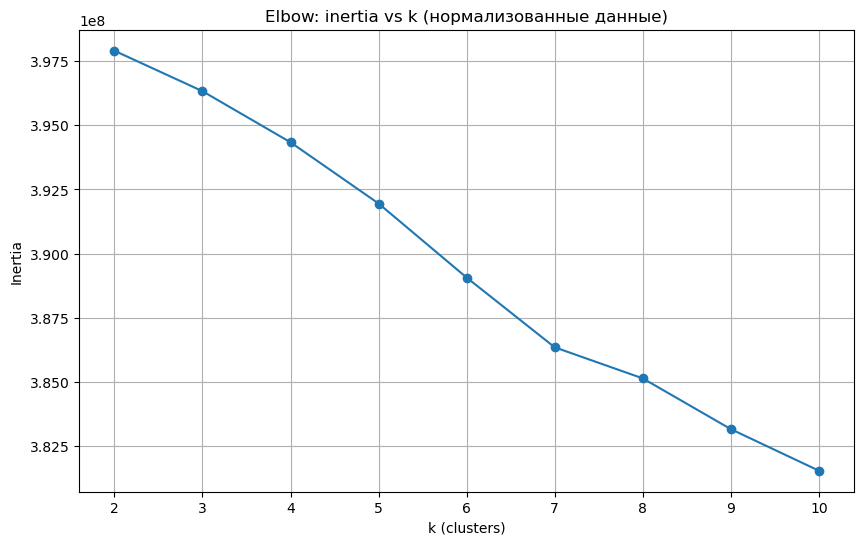

In [12]:

plt.figure(figsize=(10,6))
plt.plot(range(K_MIN, K_MAX + 1), inertias, marker='o')
plt.title('Elbow: inertia vs k (нормализованные данные)')
plt.xlabel('k (clusters)');  plt.ylabel('Inertia');  plt.grid();  plt.show()

На Elbow графике видно маленькое плечо при 7 клатерах из чего можно сделать вывод что это так сказать подходящее их количество

In [13]:
best_k=7

In [14]:
print('\nОбучаем K‑Means на полной выборке…')

scaler_full = StandardScaler(with_mean=False)
X_scaled    = scaler_full.fit_transform(X_sparse)

kmeans          = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
order_segments  = kmeans.fit_predict(X_scaled)

print('Готово.')


Обучаем K‑Means на полной выборке…
Готово.


In [15]:

print('\nОписание кластеров (топ‑10 категорий)…')

if 'aisles' not in globals():
    aisles = pd.read_csv(DATA_DIR / 'aisles.csv',
                         dtype={'aisle_id': 'int16', 'aisle': 'category'})
aisle_name = aisles.set_index('aisle_id')['aisle'].to_dict()

desc_rows = []
for c in range(best_k):
    orders_c = set(order_ids[order_segments == c])
    aisles_c = filtered_order_products[
        filtered_order_products['order_id'].isin(orders_c)
    ]['aisle_id']
    top10 = aisles_c.value_counts().head(10)
    top10_names = [aisle_name[a] for a in top10.index]
    print(f'\nКластер {c} (orders={len(orders_c):,}):')
    for a_id, name, cnt in zip(top10.index, top10_names, top10.values):
        print(f'  {name:<30} {cnt:,}')
    desc_rows.append({
        'cluster': c,
        'orders' : len(orders_c),
        **{f'top{i+1}': aisle_name[a] for i, a in enumerate(top10.index)}
    })

cluster_desc = pd.DataFrame(desc_rows)


Описание кластеров (топ‑10 категорий)…

Кластер 0 (orders=2,684,772):
  milk                           792,997
  water seltzer sparkling water  774,155
  chips pretzels                 668,404
  soy lactosefree                585,628
  refrigerated                   531,436
  bread                          501,084
  frozen produce                 471,426
  ice cream ice                  455,367
  energy granola bars            433,980
  crackers                       415,988

Кластер 1 (orders=51,362):
  canned fruit applesauce        49,103
  milk                           14,831
  body lotions soap              14,813
  bread                          9,681
  water seltzer sparkling water  9,649
  chips pretzels                 9,612
  crackers                       8,288
  baby food formula              7,879
  refrigerated                   7,658
  soy lactosefree                7,188

Кластер 2 (orders=13,192):
  other                          14,050
  water seltzer sparkling wate

📊 Описание кластеров (топ-10 категорий)

    Кластер 0 (2,684,772 заказов)
    Общие покупки повседневных продуктов.
    Популярны молочные продукты, вода, снеки, хлеб, замороженные овощи и десерты. Основной сегмент массовых домохозяйств.

    Кластер 1 (51,362 заказа)
    Семьи с маленькими детьми.
    Высокая доля консервированных фруктов, детских товаров (детское питание, мыло), стандартные категории для дома.

    Кластер 2 (13,192 заказа)
    Редкие или случайные покупатели.
    Большая доля прочих товаров ("other"), базовые категории: вода, молоко, снеки. Поведение неустойчивое.

    Кластер 3 (14,774 заказа)
    Покупатели, готовящие дома.
    Преобладают крупы, мясные консервы, молочные продукты, травы и ингредиенты для приготовления блюд.

    Кластер 4 (301,213 заказов)
    Любители пасты и полуфабрикатов.
    Высокий спрос на макароны, соусы, готовые блюда. Преобладают быстрые решения для ужина.

    Кластер 5 (16,808 заказов)
    Покупатели алкоголя.
    Доминируют вина, пиво, спиртные напитки. Дополнительно — снеки и прохладительные напитки.

    Кластер 6 (173,799 заказов)
    Покупатели товаров для дома.
    Основной акцент на хозяйственные товары: бумажная продукция, чистящие средства, моющие для посуды, средства для хранения.

In [16]:
order_aisle_counts = (order_aisle > 0).sum(axis=1)

order_info = pd.DataFrame({
    'order_id'      : order_ids,
    'segment'       : order_segments,
    'num_categories': order_aisle_counts.values
})

avg_categories_per_segment = (
    order_info.groupby('segment')['num_categories'].mean()
)
print("\nСреднее число категорий в заказе по каждому кластеру:")
print(avg_categories_per_segment)


Среднее число категорий в заказе по каждому кластеру:
segment
0    5.507362
1    6.147852
2    3.852790
3    4.804251
4    6.467164
5    3.187470
6    4.774596
Name: num_categories, dtype: float64



Строим PCA‑проекцию…


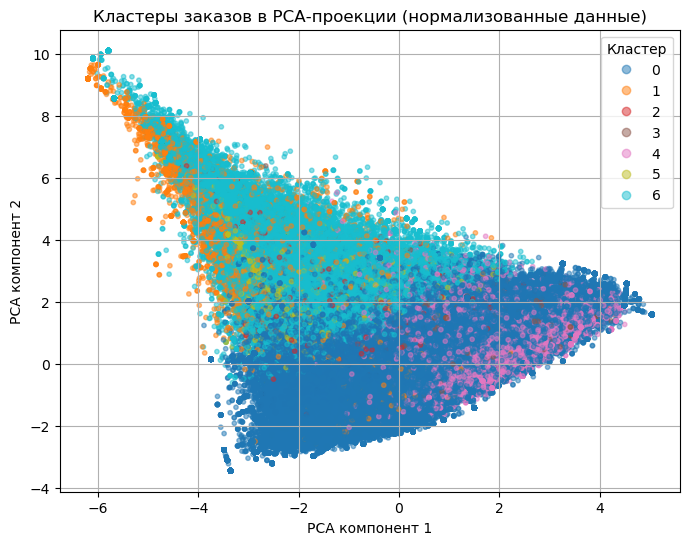

In [17]:
from sklearn.decomposition import PCA

print("\nСтроим PCA‑проекцию…")

pca   = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1],
                      c=order_segments, cmap='tab10', s=10, alpha=0.5)
plt.title("Кластеры заказов в PCA‑проекции (нормализованные данные)")
plt.xlabel("PCA компонент 1");  plt.ylabel("PCA компонент 2")
plt.legend(*scatter.legend_elements(), title="Кластер");  plt.grid(True);  plt.show()

In [18]:
order_seg_df = pd.DataFrame({'order_id': order_ids,
                             'order_segment': order_segments})
out_path = DATA_DIR / 'order_segments.csv'
order_seg_df.to_csv(out_path, index=False)
print(f'Файл сохранён → {out_path.resolve()}')

Файл сохранён → D:\instacart\archive\order_segments.csv


In [24]:
# %% [save_artifacts]  ← после расчёта cluster_desc
from pathlib import Path
import joblib, gc, json

ART_DIR = Path('model_artifacts'); ART_DIR.mkdir(exist_ok=True, parents=True)

# 1️⃣  scaler + kmeans
joblib.dump(scaler_full, ART_DIR/'scaler.pkl')
joblib.dump(kmeans,      ART_DIR/'kmeans.pkl')

# 2️⃣  список признаков (строковые названия aisle!)
aisle_cols_names = [aisle_name[a] for a in order_aisle.columns]
json.dump(aisle_cols_names, open(ART_DIR/'aisle_columns.json','w'))

# 3️⃣  product_id → aisle_name  (только внутри оставшихся 123 категорий)
valid_products = products[products['aisle_id'].isin(order_aisle.columns)]
prod2aisle = (
    valid_products
      .merge(aisles, on='aisle_id', how='left')
      .set_index('product_id')['aisle']
      .to_dict()
)
joblib.dump(prod2aisle, ART_DIR/'product2aisle.pkl')

# 4️⃣  частые aisle (те же 123)
json.dump(aisle_cols_names, open(ART_DIR/'frequent_aisles.json','w'))

# 5️⃣  описание кластеров (для справки)
cluster_desc.to_csv(ART_DIR/'cluster_desc.csv', index=False)

print('✅ Артефакты сохранены в', ART_DIR.resolve())
gc.collect()

✅ Артефакты сохранены в C:\Users\nezir\OneDrive\Рабочий стол\ipynb\recsys retail rocket\model_artifacts


32